In [1]:
from gensim.models import Word2Vec
from gensim import models
import wikipedia
from nltk import word_tokenize, sent_tokenize
import re
import torch
from torch import nn
import numpy as np
from tqdm import tqdm
import torch.utils.data as td
import matplotlib.pyplot as plt

In [2]:
def get_articles(search_terms, results, include_random=True):
    article_text = {}
    for term in search_terms:
        articles = wikipedia.search(term,results=results)
        for article in articles:
            try:
                article_text[article] = wikipedia.page(article, auto_suggest=False).content
            except wikipedia.exceptions.DisambiguationError as e:
                for a in e.options:
                    try:
                        article_text[a] = wikipedia.page(a, auto_suggest=False).content
                        print(f"accepted alt {a}")
                    except wikipedia.exceptions.DisambiguationError as e:
                        print(f"tossing alt {a}")
                    except wikipedia.exceptions.PageError as e:
                        print(f"tossing alt {a}")
            except wikipedia.exceptions.PageError as e:
                print(f"tossing {article} p")
    return article_text

def tokenize_article(article_text):
    article_text = article_text.lower()
    article_text = re.sub(r'[^a-zA-Z\s.]', '', article_text)
    sentences = sent_tokenize(article_text)
    tokenized_text = [word_tokenize(sentence) for sentence in sentences]
    return tokenized_text

def build_corpus(search_terms, results, include_random=True):
    corpus = []
    articles = get_articles(search_terms, results, include_random=include_random)
    for title,content in articles.items():
        corpus.extend(tokenize_article(content))
    return corpus

In [3]:
vectorizer = Word2Vec.load("./vectorizers/initial_model_128.model")

In [4]:
vectorizer.wv.__len__()

255

In [41]:
# MAKE SURE YOU ADD ANY LAYERS TO THE FORWARD FUNCTION
# THE GOAL IS COLOR
class Encoder(nn.Module):
    def __init__(self, vec_size):
        super().__init__()
        self.dense1 = nn.Linear(vec_size, 256, bias=False)
        self.dense2 = nn.Linear(256,768,bias=False)
        # Try upscaling more linearly, but make sure it is a square number that can be upscaled by 2 to 128
        
        self.upsample1 = nn.ConvTranspose2d(3, 3, kernel_size = 4, stride=2, padding=1, bias=False)
        self.conv1 = nn.Conv2d(3,3,3,padding=1, bias=False)
        self.conv12 = nn.Conv2d(3,3,5,padding=2, bias=False)
        self.upsample2 = nn.ConvTranspose2d(3, 3, kernel_size = 4, stride=2, padding=1, bias=False)
        self.conv2 = nn.Conv2d(3,3,3,padding=1, bias=False)
        self.conv22 = nn.Conv2d(3,3,5,padding=2, bias=False)
        self.upsample3 = nn.ConvTranspose2d(3, 3, kernel_size = 4, stride=2, padding=1, bias=False)
        self.conv3 = nn.Conv2d(3,3,3,padding=1, bias=False)
        self.conv32 = nn.Conv2d(3,3,5,padding=2, bias=False)
        # Try modifying the in/out channels and kernel sizes here. 
        # Can also add normal Conv layers between these, just make sure padding = kernel_size // 2
        
        self.mesh = nn.Conv2d(6, 3, 3, padding=1, bias=False)
        # Try adding additional layers here, since this is the place where
        # the current sentence image is merged with the word
        # NEW: Skip connection layers to merge low- and high-level features
        self.skip1 = nn.Conv2d(3, 3, 1, bias=False)  # Merges features after first upsample
        self.skip2 = nn.Conv2d(3, 3, 1, bias=False)  # Merges features after second upsample
        self.skip3 = nn.Conv2d(3, 3, 1, bias=False)  # Merges features after third upsample

        # NEW: Edge enhancement layers to reduce blur
        self.sharp1 = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        self.sharp2 = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        
    def forward(self, simage, word_vec):
        
        x = self.dense1(word_vec)
        x = nn.functional.silu(x)
        
        x = self.dense2(x)
        x = nn.functional.silu(x)
        
        x = x.reshape((-1,3,16,16))
        
        x = self.upsample1(x)
        x = self.sharp1(x) 
        x = nn.functional.silu(x)
        skip_x1 = self.skip1(x)  # NEW: Capture details
        x = self.conv1(x)
        x = nn.functional.silu(x)
        x = self.conv12(x)
        x = nn.functional.silu(x)

        x = self.upsample2(x)
        x = self.sharp2(x) 
        x = nn.functional.silu(x)
        skip_x2 = self.skip2(x)
        x = self.conv2(x)
        x = nn.functional.silu(x)
        x = self.conv22(x)
        x = nn.functional.silu(x)

        x = self.upsample3(x)
        x = nn.functional.silu(x) # <- This activation function should result in something image-like, silu isn't great
        skip_x3 = self.skip3(x)
        x = self.conv3(x)
        x = nn.functional.silu(x)
        x = self.conv32(x)
        x = nn.functional.silu(x)

        # Make modifications here too
        # Upsample skip_x1 and skip_x2 to match x's dimensions
        skip_x1_resized = nn.functional.interpolate(skip_x1, size=x.shape[2:], mode="bilinear", align_corners=True)
        skip_x2_resized = nn.functional.interpolate(skip_x2, size=x.shape[2:], mode="bilinear", align_corners=True)

        # Merge the resized skip connections with x
        x = x + skip_x1_resized + skip_x2_resized + skip_x3
        x = torch.concat((simage, x), dim=1)
        return self.mesh(x)
    
class Decoder(nn.Module):
    def __init__(self, vec_size, vocab_size):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        self.conv3 = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        
        self.pool1 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        self.pool2 = nn.MaxPool2d(2)
        self.conv5 = nn.Conv2d(3,6,3,padding=1, bias=False)
        self.pool3 = nn.MaxPool2d(2)
        self.conv6 = nn.Conv2d(6,1,3,padding=1, bias=False)
        
        self.flatten = nn.Flatten()
        self.classify1 = nn.Linear(256,256, bias=False)
        self.classify2 = nn.Linear(256,vec_size, bias=False)
        self.classify3 = nn.Linear(vec_size, vocab_size, bias=False)
        
        self.next1 = nn.Conv2d(3,16,3,padding=1, bias=False)
        self.next2 = nn.Conv2d(16,16,3,padding=1, bias=False)
        self.next3 = nn.Conv2d(16, 3, 1, bias=False)
        
        
    def forward(self, input):
        
        skip = input
        
        x = self.conv1(input)
        x = nn.functional.silu(x)
        x = self.conv2(x)
        x = nn.functional.silu(x)
        x = self.conv3(x)
        x = nn.functional.silu(x)
        
        c = self.pool1(x)
        c = self.conv4(c)
        c = nn.functional.silu(c)
        c = self.pool2(c)
        c = self.conv5(c)
        c = nn.functional.silu(c)
        c = self.pool3(c)
        c = self.conv6(c)
        c = nn.functional.silu(c)

        c = self.flatten(c)
        #c = torch.concat((c, context), dim=1)
        c = self.classify1(c)
        c = nn.functional.silu(c)
        co = self.classify2(c)
        c = nn.functional.silu(co)
        c = self.classify3(c)
        
        n = self.next1(x)
        n = nn.functional.silu(n)
        n = self.next2(n)
        n = nn.functional.silu(n)
        #context = n.clone()
        n = self.next3(n)
        n = x - n
        
        return n, c

In [42]:
def enc_from_vec(encoder, sent_vec):
    simage = torch.zeros(size=(1,3,128,128))
    for word in sent_vec:
        simage = encoder(simage, word)
    return simage

def dec_from_simage(decoder, simage):
    outs = []
    for i in range(10):
        simage, word = decoder(simage)
        outs.append(word)
    return outs

def words_from_idx(vectorizer, sent):
    outs = []
    for word in sent:
        outs.append(vectorizer.wv.index_to_key[word])
    return outs

In [22]:
corpus = build_corpus(["philosophy", "government", "cooking", "writing"], 5)
print("corpus built")

c:\Users\Alexander\Documents\Dreamer\.conda\Lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\Alexander\Documents\Dreamer\.conda\Lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


accepted alt Graffiti
accepted alt Tony Namate
accepted alt The Writing on the Wall (film)
tossing alt "The Writing on the Wall" (Yes Minister)
tossing alt The Writing on the Wall (1996 film)
tossing alt "The Writing on the Wall" (Agents of S.H.I.E.L.D.)
tossing alt episode of The Apprentice 3
accepted alt Indigo Books and Music
accepted alt The Transylvanian Trilogy
accepted alt Phillip Whitehead
accepted alt Guy N. Smith
accepted alt Sundararajan Padmanabhan
accepted alt Lynne Sharon Schwartz
accepted alt Will Hutton
accepted alt Writing on the Wall (band)
accepted alt The Writing's on the Wall
accepted alt Writing on the Wall (Bucks Fizz album)
accepted alt One Way System
accepted alt Desmond Dekker
accepted alt Jill Phillips
accepted alt Gucci Mane
tossing alt "The Writing on the Wall" (Adam Wade song)
tossing alt "Writing's on the Wall" (George Harrison song)
tossing alt "The Writing's on the Wall" (OK Go song)
tossing alt "Writing's on the Wall" (Sam Smith song)
tossing alt "Writ

In [23]:
import random
enc_corpus = [[torch.from_numpy(vectorizer.wv[w]) for w in s if w in vectorizer.wv.key_to_index] for s in corpus]
enc_corpus = [e for e in enc_corpus if len(e) > 1]
w_corpus = [[w for w in s if w in vectorizer.wv.key_to_index] for s in corpus]
w_corpus = [w for w in w_corpus if len(w) >  1]
temp = list(zip(enc_corpus, w_corpus))  # Pair the elements
random.shuffle(temp)  # Shuffle the pairs
enc_corpus, w_corpus = zip(*temp)
enc_corpus = enc_corpus[:500]
w_corpus = w_corpus[:500]

In [24]:
vocab_size = len(vectorizer.wv)

In [43]:
encode = Encoder(128)
decode = Decoder(128,vocab_size)
s = nn.Sequential(encode,decode)

In [44]:
a = encode(torch.from_numpy(np.zeros((1,3,128,128), dtype=np.float32)), torch.from_numpy(vectorizer.wv["example"]))
b = decode(a)#, torch.zeros((1,128)))
print(b[0].shape, b[1].shape)

torch.Size([1, 3, 128, 128]) torch.Size([1, 255])


In [27]:
b[1].var()

tensor(8.4480e-18, grad_fn=<VarBackward0>)

In [28]:
sum(p.numel() for p in s.parameters())

365345

In [45]:
crit_word = nn.CrossEntropyLoss()
crit_sent = nn.MSELoss()
optim = torch.optim.Adam(s.parameters())

In [46]:
w_c = vectorizer.wv.index_to_key.__len__()
w_c

255

In [47]:
class WordDataset(td.Dataset):
    
    def __init__(self, vectorizer):
        super().__init__()
        self.vocab_count = len(vectorizer.wv.index_to_key)
        self.v = vectorizer
        
    def __getitem__(self, index):
        return torch.tensor(self.v.wv[index]), torch.tensor(index)
    
    def __len__(self):
        return self.vocab_count
    
class SentenceDataset(td.Dataset):
    
    def __init__(self, vectorizer, sentence_len, num_sents):
        super().__init__()
        self.vocab_count = len(vectorizer.wv.index_to_key)
        self.num_sents = num_sents
        self.sentence_len = sentence_len
        self.v = vectorizer
        
    def __getitem__(self, index):
        idx = np.random.randint(0,self.vocab_count, size=(self.sentence_len,))
        words = np.array([self.v.wv[id] for id in idx])
        return torch.tensor(words), torch.tensor(idx).to(torch.long)

    def __len__(self):
        return self.num_sents
    
batch_size = 16
word_dataset = WordDataset(vectorizer)
word_loader = td.DataLoader(word_dataset, batch_size=batch_size, shuffle=True)

sent_dataset = SentenceDataset(vectorizer, 5, 100)
sent_loader = td.DataLoader(sent_dataset, batch_size=batch_size, shuffle=True)

mid_dataset = SentenceDataset(vectorizer, 10, 100)
mid_loader = td.DataLoader(sent_dataset, batch_size=batch_size, shuffle=True)

long_dataset = SentenceDataset(vectorizer, 15, 100)
long_loader = td.DataLoader(sent_dataset, batch_size=batch_size, shuffle=True)

In [48]:
epochs = 35
losses = []
word_acc = []
for e in tqdm(range(epochs)):
    epoch_loss = 0
    w_correct = 0
    for w, l in word_loader:
        optim.zero_grad()
        loss = 0
        simage = torch.zeros(size=(len(l),3,128,128))
        f = simage.clone()
        simage = encode(simage, w)
        simage, d = decode(simage)
        loss = loss + crit_word(d, l)
        loss = loss + crit_sent(simage, f)
        epoch_loss += loss.item()
        w_correct += sum([1 for a,label in zip(d.argmax(dim=1), l) if a == label])
        loss.backward()
        optim.step()
    word_acc.append(w_correct / 255)
    losses.append(epoch_loss)

100%|██████████| 35/35 [01:49<00:00,  3.13s/it]


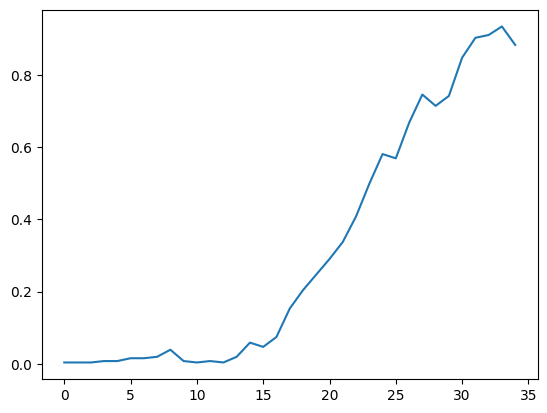

In [50]:
plt.plot(word_acc)

In [ ]:
epochs = 100
losses = []
word_loss = []
for e in tqdm(range(epochs)):
    epoch_loss = 0
    w_correct = 0
    for sentence, label in long_loader:
        optim.zero_grad()
        loss = 0
        simage = torch.zeros(size=(sentence.shape[0],3,128,128))
        f = simage.clone()
        for s in range(sentence.shape[1]):
            simage = encode(simage, sentence[:,s])
        for l in range(label.shape[1]):
            simage, d = decode(simage)
            loss = loss + crit_word(d, label[:,l]) * (5 if l in [4,5,6,7,8] else 1)
        w_correct += loss.item()
        loss = loss + crit_sent(simage, f)
        epoch_loss += loss.item()
        loss.backward()
        optim.step()
    word_loss.append(w_correct)
    losses.append(epoch_loss)

In [ ]:
plt.plot(word_loss)
plt.show()
plt.plot(np.array(losses) - np.array(word_loss))
plt.show()

In [24]:
epochs = 25
losses = []
word_loss = []
for e in tqdm(range(epochs)):
    # Initialize loss and correct
    epoch_loss = 0
    w_correct = 0
    # Train over long sentences
    for sentence, label in long_loader:
        optim.zero_grad()
        loss = 0
        simage = torch.zeros(size=(sentence.shape[0],3,128,128))
        f = simage.clone()
        for s in range(sentence.shape[1]):
            simage = encode(simage, sentence[:,s])
        for l in range(label.shape[1]):
            simage, d = decode(simage)
            loss = loss + crit_word(d, label[:,l]) * (3 if l in [0,14] else 0.6)
        w_correct += loss.item()
        loss = loss + crit_sent(simage, f) * 0.6
        epoch_loss += loss.item()
        loss.backward()
        optim.step()
    # Train over medium Sentences
    for sentence, label in mid_loader:
        optim.zero_grad()
        loss = 0
        simage = torch.zeros(size=(sentence.shape[0],3,128,128))
        f = simage.clone()
        for s in range(sentence.shape[1]):
            simage = encode(simage, sentence[:,s])
        for l in range(label.shape[1]):
            simage, d = decode(simage)
            loss = loss + crit_word(d, label[:,l]) * (3 if l in [0,9] else 0.6)
        w_correct += loss.item()
        loss = loss + crit_sent(simage, f) * 0.6
        epoch_loss += loss.item()
        loss.backward()
        optim.step()
    # Train over short sentences
    for sentence, label in sent_loader:
        optim.zero_grad()
        loss = 0
        simage = torch.zeros(size=(sentence.shape[0],3,128,128))
        f = simage.clone()
        for s in range(sentence.shape[1]):
            simage = encode(simage, sentence[:,s])
        for l in range(label.shape[1]):
            simage, d = decode(simage)
            loss = loss + crit_word(d, label[:,l]) * (3 if l in [0,4] else 0.6)
        w_correct += loss.item()
        loss = loss + crit_sent(simage, f) * 0.6
        epoch_loss += loss.item()
        loss.backward()
        optim.step()
    word_loss.append(w_correct)
    losses.append(epoch_loss)

100%|██████████| 25/25 [17:26<00:00, 41.86s/it]


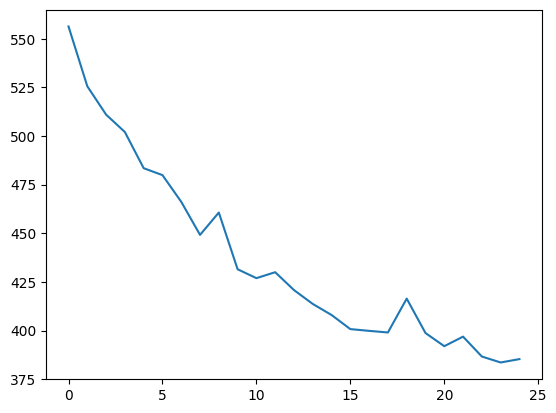

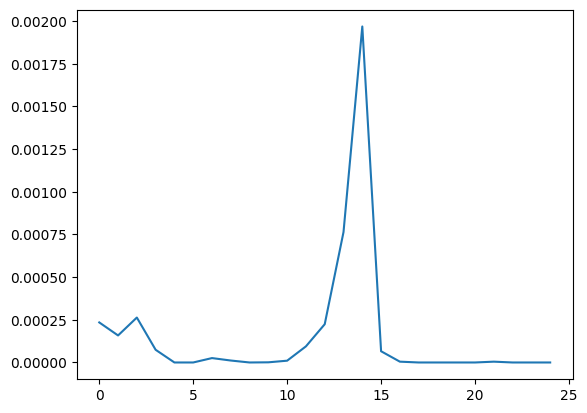

In [25]:
plt.plot(word_loss)
plt.show()
plt.plot(np.array(losses) - np.array(word_loss))
plt.show()

In [ ]:
## Training Loop ##
for wsen,sentence in tqdm(list(zip(w_corpus,enc_corpus))):
    optim.zero_grad()
    f = torch.normal(mean=0,std=0.4,size=(1,3,128,128))
    simage = f.clone()
    for w in sentence:
        simage = encode(simage, w)
    outputs = []
    loss = torch.tensor(0.0, requires_grad=True, device=simage.device)
    #context = torch.zeros((1,128), device=simage.device)
    for i,w in enumerate(sentence):
        simage, out = decode(simage)
        outputs.append(vectorizer.wv.index_to_key[out.argmax()])
        w_idx = vectorizer.wv.get_index(wsen[i])
        if len(outputs) > 1 and outputs[-1] == outputs[-2]:
            loss = loss - crit_word(out,out.argmax().unsqueeze(0))
        else:
            loss = loss + crit_word(out,torch.tensor([w_idx]))
    print(outputs)
    loss = loss / len(sentence)
    loss.backward()
    optim.step()

In [21]:
s = 4
encoded = enc_from_vec(encode, enc_corpus[s])
simage = encoded.clone()
display(w_corpus[s])
for i in range(20):
    simage, out = decode(simage)
    print(vectorizer.wv.index_to_key[out.argmax()])

['as',
 'also',
 'have',
 'some',
 'for',
 'the',
 'work',
 'of',
 'the',
 'its',
 'and',
 'with',
 'other',
 'government',
 '.']

references
many
many
many
many
many
many
many
many
many
many
many
many
many
many
many
many
many
many
many


In [ ]:
torch.save(decode,"decoder2.pt")
torch.save(encode,"encoder2.pt")